<h1> Scan 11 MD Map </h1>

In [1]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [2]:
# Loading in Image 

img_nifti = nib.load("cdmri11_r.nii")

img =img_nifti.dataobj[:,:,:,:]


In [3]:
img.shape

(77, 92, 56, 1344)

In [4]:
# Loading in Mask

mask_nifti = nib.load("cdmri11_mask.nii")

mask = mask_nifti.dataobj[:,:,:]

In [5]:
# Final Image 

arr = img.copy()
for i in range (0,1344):
    arr[:,:,:,i] = mask*img[:,:,:,i]; 

In [6]:
arr.shape

(77, 92, 56, 1344)

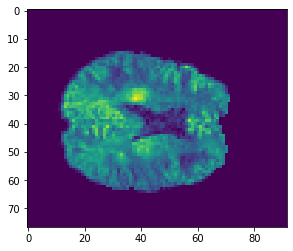

In [7]:
plt.imshow(arr[:,:,33,200])

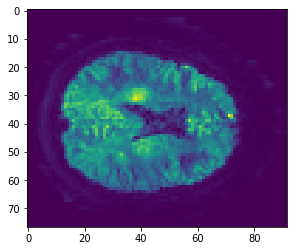

In [8]:
plt.imshow(img[:,:,33,200])

In [9]:
MD_map = np.zeros([77,92])

T1_map = np.zeros([77,92])
T2_map = np.zeros([77,92])
IE_map = np.zeros([77,92])

cost_map = np.zeros([77,92])
D_map = np.zeros([77,92,3,3])
FA_map = np.zeros([77,92])

MD_map_abs = np.zeros([77,92])

In [10]:
# Importing Parameters

p = np.loadtxt('parameters_new.txt')
p.shape

(1344, 6)

In [11]:
param = np.zeros([1344,6])
param = p.copy()
# Switching first two columns as:
# [x y z] --> [y -x z] (scanner to measurement coordinate system)
param[:, 0], param[:, 1] = p[:, 1], p[:, 0].copy()
param[:,1] = -param[:,1]

# had to check, but is correct
# np.savetxt('changed_param.txt', param, fmt='%1.5f')

param

array([[-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.0000e+01,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  1.2364e+03,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.4727e+03,
         8.0000e+01],
       ...,
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  2.2961e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  3.5325e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  7.3227e+03,
         1.3000e+02]])

In [12]:
b = p[:,3]
TI = p[:,4]
TE = p[:,5]

# Filter based on TI fulfilling condition
vals = TI>TI_limit
indices = np.where(TI>TI_limit)
b0idx = np.where(b==0)   

TI=TI[indices]
TE=TE[indices]
param=param[indices]
b=b[indices]
res_selected = arr[:,:,:,indices]

In [13]:
# From Stackoverflow: https://stackoverflow.com/questions/45637778/how-to-find-intersect-indexes-and-values-in-python
# Function takes unique elements from each array, puts them together, and concatenates
import numpy as np
def intersect_mtlb(a, b):
    a1, ia = np.unique(a, return_index=True)
    b1, ib = np.unique(b, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]

c, idx_b0, ib = intersect_mtlb(indices, b0idx )

# s0init = np.mean(arr[:,:,:,idx_b0], axis = 3) 

# Initial Values and Objective Function
b=b/1000
x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]

boundaries = [0, 1, 0, 10, 0, 0, 0, -np.inf, -np.inf, -np.inf], [np.inf, 2, 2e7, 350, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]

# Note: Thilo has no bounds on fit

<h2> Creating Model </h2>

In [14]:
# Fit Function

def Fit(x,b, TI, TR, TE, param):            

    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    return S

# Simple Exponential Cost Function

def FitCost(x, b, TI, TR, TE, param, slslice):   
    # x[0] : Amplitude
    # x[1] : D value
    
    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    res = slslice[0,:] -S
    return res

In [15]:


def MD(b, TI, TR, TE, param, slslice, boundaries):

    # Perform Non-Linear Least Squares Fit

    x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]
    # for x[4], values of 0.01, 1 would lead to a straight line at 0, 
    # while 10 and 100 works fine

    lsr = least_squares(FitCost, x0, args=(b,TI, TR, TE, param, slslice), bounds=(boundaries), max_nfev=5000)
    cost = lsr.cost
    jac = lsr.jac
    values = lsr.x

    # Computing Mean Diffusivity
    # Diffusion Tensor
    D = [[values[4], values[7], values[8]], 
         [values[7], values[5], values[9]], 
         [values[8], values[9], values[6]]]

    # Eigenvectors and Eigenvalues 
    [evecs , evals] = la.eig(D)
    i = np.argsort(np.diag(evals))
    evals = np.diag(evals)[i]

    # Calculating MD 
    MD = (evals[0]+evals[1]+evals[2])/3
    return MD


def Maps(b, TI, TR, TE, param, slslice, boundaries):

    # Perform Non-Linear Least Squares Fit

    x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]
    # for x[4], values of 0.01, 1 would lead to a straight line at 0, 
    # while 10 and 100 works fine

    lsr = least_squares(FitCost, x0, args=(b,TI, TR, TE, param, slslice), bounds=(boundaries), max_nfev=5000)
    cost = lsr.cost
    jac = lsr.jac
    values = lsr.x

    # Computing Mean Diffusivity
    # Diffusion Tensor
    D = [[values[4], values[7], values[8]], 
         [values[7], values[5], values[9]], 
         [values[8], values[9], values[6]]]

    # Eigenvectors and Eigenvalues 
    [evals , evecs] = la.eig(D)
    
    # Calculating MD 
    MD = (evals[0]+evals[1]+evals[2])/3
    FA = np.sqrt(1/2)*((np.sqrt((evals[0]-evals[1])**2+(evals[1]-evals[2])**2+(evals[2]-evals[0])**2))/np.sqrt(evals[0]**2+evals[1]**2+evals[2]**2))
    return MD, values[1],values[2],values[3], cost, D, FA

    # values[3]: T2* , [2]: T1, [1]: PD?, i.e. IE

<h2> Model Fit for All Pixels </h2>

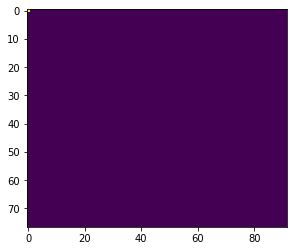

In [16]:
# Testing on One Voxel

slslice = res_selected[0,0,33,:]
MD_map[0,0], IE_map[0,0],T1_map[0,0],T2_map[0,0], cost_map[0,0], D_map[0,0], FA_map[0,0] = Maps(b, TI, TR, TE, param, slslice, boundaries)
plt.imshow(MD_map)

In [17]:
# Igonring Imaginary part

# Loop through Voxels
for i in range (77):
    for j in range (92):
        print(i, "   " ,j )
        slslice = res_selected[i,j,33,:]
        MD_map[i,j], IE_map[i,j],T1_map[i,j],T2_map[i,j], cost_map[i,j], D_map[i,j], FA_map[i,j]= Maps(b, TI, TR, TE, param, slslice, boundaries)


0     0
0     1
0     2
0     3
0     4
0     5
0     6
0     7
0     8
0     9
0     10
0     11
0     12
0     13
0     14
0     15
0     16
0     17
0     18
0     19
0     20
0     21
0     22
0     23
0     24
0     25
0     26
0     27
0     28
0     29
0     30
0     31
0     32
0     33
0     34
0     35
0     36
0     37
0     38
0     39
0     40
0     41
0     42
0     43
0     44
0     45
0     46
0     47
0     48
0     49
0     50
0     51
0     52
0     53
0     54
0     55
0     56
0     57
0     58
0     59
0     60
0     61
0     62
0     63
0     64
0     65
0     66
0     67
0     68
0     69
0     70
0     71
0     72
0     73
0     74
0     75
0     76
0     77
0     78
0     79
0     80
0     81
0     82
0     83
0     84
0     85
0     86
0     87
0     88
0     89
0     90
0     91
1     0
1     1
1     2
1     3
1     4
1     5
1     6
1     7
1     8
1     9
1     10
1     11
1     12
1     13
1     14
1     15
1     16
1     17
1     18
1     19
1     20
1  

10     4
10     5
10     6
10     7
10     8
10     9
10     10
10     11
10     12
10     13
10     14
10     15
10     16
10     17
10     18
10     19
10     20
10     21
10     22
10     23
10     24
10     25
10     26
10     27
10     28
10     29
10     30
10     31
10     32
10     33
10     34
10     35
10     36
10     37
10     38
10     39
10     40
10     41
10     42
10     43
10     44
10     45
10     46
10     47
10     48
10     49
10     50
10     51
10     52
10     53
10     54
10     55
10     56
10     57
10     58
10     59
10     60
10     61
10     62
10     63
10     64
10     65
10     66
10     67
10     68
10     69
10     70
10     71
10     72
10     73
10     74
10     75
10     76
10     77
10     78
10     79
10     80
10     81
10     82
10     83
10     84
10     85
10     86
10     87
10     88
10     89
10     90
10     91
11     0
11     1
11     2
11     3
11     4
11     5
11     6
11     7
11     8
11     9
11     10
11     11
11     12
11    

19     6
19     7
19     8
19     9
19     10
19     11
19     12
19     13
19     14
19     15
19     16
19     17
19     18
19     19
19     20
19     21
19     22
19     23
19     24
19     25
19     26
19     27
19     28
19     29
19     30
19     31
19     32
19     33
19     34
19     35
19     36
19     37
19     38
19     39
19     40
19     41
19     42
19     43
19     44
19     45
19     46
19     47
19     48
19     49
19     50
19     51
19     52
19     53
19     54
19     55
19     56
19     57
19     58
19     59
19     60
19     61
19     62
19     63
19     64
19     65
19     66
19     67
19     68
19     69
19     70
19     71
19     72
19     73
19     74
19     75
19     76
19     77
19     78
19     79
19     80
19     81
19     82
19     83
19     84
19     85
19     86
19     87
19     88
19     89
19     90
19     91
20     0
20     1
20     2
20     3
20     4
20     5
20     6
20     7
20     8
20     9
20     10
20     11
20     12
20     13
20     14
20  

28     7
28     8
28     9
28     10
28     11
28     12
28     13
28     14
28     15
28     16
28     17
28     18
28     19
28     20
28     21
28     22
28     23
28     24
28     25
28     26
28     27
28     28
28     29
28     30
28     31
28     32
28     33
28     34
28     35
28     36
28     37
28     38
28     39
28     40
28     41
28     42
28     43
28     44
28     45
28     46
28     47
28     48
28     49
28     50
28     51
28     52
28     53
28     54
28     55
28     56
28     57
28     58
28     59
28     60
28     61
28     62
28     63
28     64
28     65
28     66
28     67
28     68
28     69
28     70
28     71
28     72
28     73
28     74
28     75
28     76
28     77
28     78
28     79
28     80
28     81
28     82
28     83
28     84
28     85
28     86
28     87
28     88
28     89
28     90
28     91
29     0
29     1
29     2
29     3
29     4
29     5
29     6
29     7
29     8
29     9
29     10
29     11
29     12
29     13
29     14
29     15
29 

37     8
37     9
37     10
37     11
37     12
37     13
37     14
37     15
37     16
37     17
37     18
37     19
37     20
37     21
37     22
37     23
37     24
37     25
37     26
37     27
37     28
37     29
37     30
37     31
37     32
37     33
37     34
37     35
37     36
37     37
37     38
37     39
37     40
37     41
37     42
37     43
37     44
37     45
37     46
37     47
37     48
37     49
37     50
37     51
37     52
37     53
37     54
37     55
37     56
37     57
37     58
37     59
37     60
37     61
37     62
37     63
37     64
37     65
37     66
37     67
37     68
37     69
37     70
37     71
37     72
37     73
37     74
37     75
37     76
37     77
37     78
37     79
37     80
37     81
37     82
37     83
37     84
37     85
37     86
37     87
37     88
37     89
37     90
37     91
38     0
38     1
38     2
38     3
38     4
38     5
38     6
38     7
38     8
38     9
38     10
38     11
38     12
38     13
38     14
38     15
38     16
38

46     11
46     12
46     13
46     14
46     15
46     16
46     17
46     18
46     19
46     20
46     21
46     22
46     23
46     24
46     25
46     26
46     27
46     28
46     29
46     30
46     31
46     32
46     33
46     34
46     35
46     36
46     37
46     38
46     39
46     40
46     41
46     42
46     43
46     44
46     45
46     46
46     47
46     48
46     49
46     50
46     51
46     52
46     53
46     54
46     55
46     56
46     57
46     58
46     59
46     60
46     61
46     62
46     63
46     64
46     65
46     66
46     67
46     68
46     69
46     70
46     71
46     72
46     73
46     74
46     75
46     76
46     77
46     78
46     79
46     80
46     81
46     82
46     83
46     84
46     85
46     86
46     87
46     88
46     89
46     90
46     91
47     0
47     1
47     2
47     3
47     4
47     5
47     6
47     7
47     8
47     9
47     10
47     11
47     12
47     13
47     14
47     15
47     16
47     17
47     18
47     19


55     14
55     15
55     16
55     17
55     18
55     19
55     20
55     21
55     22
55     23
55     24
55     25
55     26
55     27
55     28
55     29
55     30
55     31
55     32
55     33
55     34
55     35
55     36
55     37
55     38
55     39
55     40
55     41
55     42
55     43
55     44
55     45
55     46
55     47
55     48
55     49
55     50
55     51
55     52
55     53
55     54
55     55
55     56
55     57
55     58
55     59
55     60
55     61
55     62
55     63
55     64
55     65
55     66
55     67
55     68
55     69
55     70
55     71
55     72
55     73
55     74
55     75
55     76
55     77
55     78
55     79
55     80
55     81
55     82
55     83
55     84
55     85
55     86
55     87
55     88
55     89
55     90
55     91
56     0
56     1
56     2
56     3
56     4
56     5
56     6
56     7
56     8
56     9
56     10
56     11
56     12
56     13
56     14
56     15
56     16
56     17
56     18
56     19
56     20
56     21
56     22


64     15
64     16
64     17
64     18
64     19
64     20
64     21
64     22
64     23
64     24
64     25
64     26
64     27
64     28
64     29
64     30
64     31
64     32
64     33
64     34
64     35
64     36
64     37
64     38
64     39
64     40
64     41
64     42
64     43
64     44
64     45
64     46
64     47
64     48
64     49
64     50
64     51
64     52
64     53
64     54
64     55
64     56
64     57
64     58
64     59
64     60
64     61
64     62
64     63
64     64
64     65
64     66
64     67
64     68
64     69
64     70
64     71
64     72
64     73
64     74
64     75
64     76
64     77
64     78
64     79
64     80
64     81
64     82
64     83
64     84
64     85
64     86
64     87
64     88
64     89
64     90
64     91
65     0
65     1
65     2
65     3
65     4
65     5
65     6
65     7
65     8
65     9
65     10
65     11
65     12
65     13
65     14
65     15
65     16
65     17
65     18
65     19
65     20
65     21
65     22
65     23


73     17
73     18
73     19
73     20
73     21
73     22
73     23
73     24
73     25
73     26
73     27
73     28
73     29
73     30
73     31
73     32
73     33
73     34
73     35
73     36
73     37
73     38
73     39
73     40
73     41
73     42
73     43
73     44
73     45
73     46
73     47
73     48
73     49
73     50
73     51
73     52
73     53
73     54
73     55
73     56
73     57
73     58
73     59
73     60
73     61
73     62
73     63
73     64
73     65
73     66
73     67
73     68
73     69
73     70
73     71
73     72
73     73
73     74
73     75
73     76
73     77
73     78
73     79
73     80
73     81
73     82
73     83
73     84
73     85
73     86
73     87
73     88
73     89
73     90
73     91
74     0
74     1
74     2
74     3
74     4
74     5
74     6
74     7
74     8
74     9
74     10
74     11
74     12
74     13
74     14
74     15
74     16
74     17
74     18
74     19
74     20
74     21
74     22
74     23
74     24
74     25


Text(0.5, 1.0, 'MD Map')

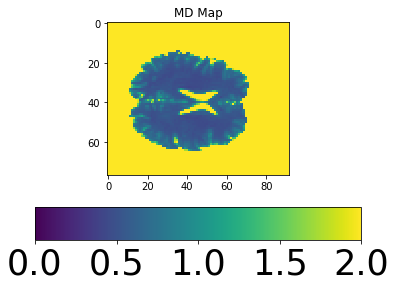

In [68]:
# Plotting Image of MD Map

plt.imshow(MD_map)
cbar = plt.colorbar(ticks=[0, 0.5, 1, 1.5, 2], orientation='horizontal', aspect = 10)
cbar.ax.tick_params(labelsize=35)
plt.clim(0, 2)
plt.title('MD Map')

Text(0.5, 1.0, 'FA Map')

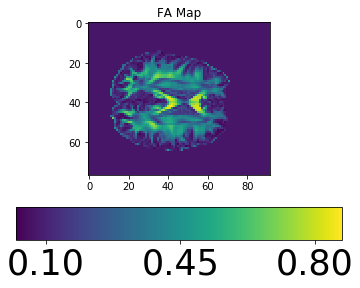

In [61]:
# Plotting Fractional Anisotropy

plt.imshow(FA_map)
cbar = plt.colorbar(ticks=[0.1, 0.45, 0.8], orientation='horizontal', aspect = 10)
cbar.ax.tick_params(labelsize=35)
plt.title('FA Map')

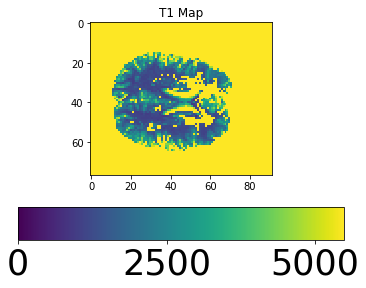

In [62]:
# Plotting Image of T1 Map

plt.imshow(T1_map)
plt.title('T1 Map')
plt.clim(0, 5.5e3)
cbar = plt.colorbar(ticks=[0, 2500, 5000], orientation='horizontal', aspect = 10)
cbar.ax.tick_params(labelsize=35)

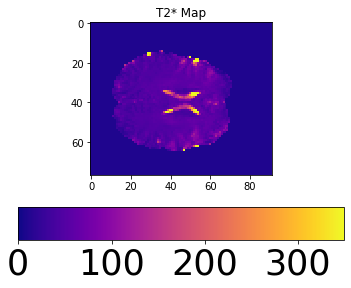

In [66]:
# Plotting Image of T2 Map

plt.imshow(T2_map, cmap = 'plasma')
plt.title('T2* Map')
plt.clim(0,350)
cbar = plt.colorbar(ticks=[0, 100, 200, 300], orientation='horizontal', aspect = 10)
cbar.ax.tick_params(labelsize=35)

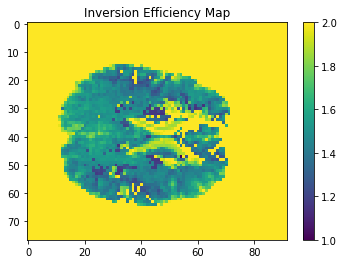

In [22]:
# Plotting Image of  Map

plt.imshow(IE_map)
plt.title('Inversion Efficiency Map')
plt.clim(1,2)
plt.colorbar()

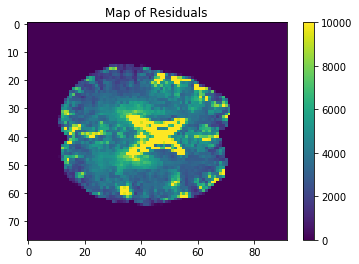

In [23]:
# Plotting Residuals

plt.imshow(cost_map)
plt.title('Map of Residuals')
plt.clim(0, 10000)
plt.colorbar()

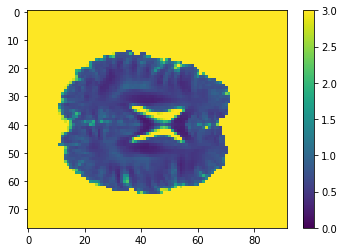

In [24]:
# Examining Diffusion Tensor
# Plotting 1st
plt.imshow(D_map[:,:,0,0])
plt.colorbar()
plt.clim(0,3)

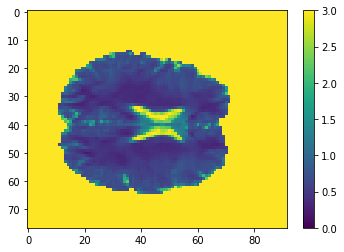

In [25]:
# Plotting 1st
plt.imshow(D_map[:,:,1,1])
plt.colorbar()
plt.clim(0,3)

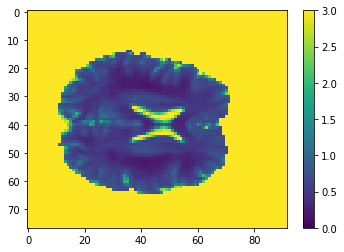

In [26]:
# Plotting 1st
plt.imshow(D_map[:,:,2,2])
plt.colorbar()
plt.clim(0,3)

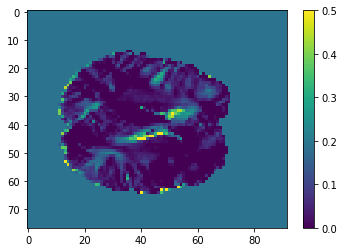

In [27]:
# Plotting 1st
plt.imshow(D_map[:,:,0,1])
plt.colorbar()
plt.clim(0,0.5)

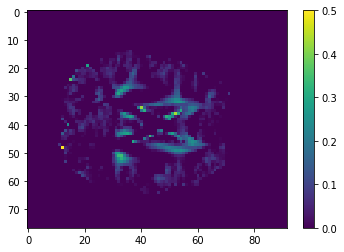

In [28]:
# Plotting 1st
plt.imshow(D_map[:,:,2,0])
plt.colorbar()
plt.clim(0,0.5)

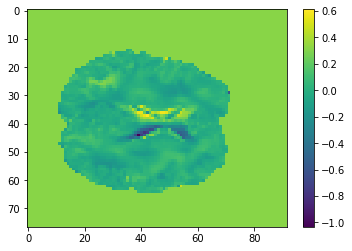

In [29]:
# Plotting 1st
plt.imshow(D_map[:,:,2,1])
plt.colorbar()
#plt.clim(0,0.4)